In [1]:
import sys

sys.path.append("..")

In [2]:
from tensorflow import keras

In [3]:
from utils.preprocessing_utils import PreprocessingUtils

In [4]:
from utils.model_wrapper import ModelWrapper

In [5]:
preprocessing_utils = PreprocessingUtils()

Files already exist, skipping...
Loading images and labels...
Images and labels loaded successfully!
Preprocessing labels...
Labels preprocessed successfully!
Splitting data into train, test and validation sets...
Data split successfully!


In [6]:
def inception_module(x, filters: list[int]):
    tower_1 = keras.layers.Conv2D(filters[0], (1, 1), padding="same", activation="relu")(x)
    tower_1 = keras.layers.Conv2D(filters[1], (3, 3), padding="same", activation="relu")(tower_1)

    tower_2 = keras.layers.Conv2D(filters[2], (1, 1), padding="same", activation="relu")(x)
    tower_2 = keras.layers.Conv2D(filters[3], (5, 5), padding="same", activation="relu")(tower_2)

    tower_3 = keras.layers.AveragePooling2D((3, 3), strides=(1, 1), padding="same")(x)
    tower_3 = keras.layers.Conv2D(filters[4], (1, 1), padding="same", activation="relu")(tower_3)

    tower_4 = keras.layers.Conv2D(filters[5], (1, 1), padding="same", activation="relu")(x)

    concatenated = keras.layers.Concatenate(axis=-1)([tower_1, tower_2, tower_3, tower_4])
    return concatenated


def build_google_net(model_name: str):
    input_layer = keras.layers.Input(shape=preprocessing_utils.images.shape[1:])

    x = keras.layers.Conv2D(
        64, (7, 7), strides=(2, 2), padding="same", activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)
    )(input_layer)
    x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

    x = keras.layers.Conv2D(
        64, (1, 1), padding="same", activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)
    )(x)
    x = keras.layers.Conv2D(
        192, (3, 3), padding="same", activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)
    )(x)
    x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

    x = inception_module(x, [64, 128, 32, 32, 32, 32])
    x = inception_module(x, [128, 192, 96, 64, 64, 64])

    x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = keras.layers.Dropout(0.5)(x)

    output_layer = keras.layers.Dense(preprocessing_utils.num_classes, activation="softmax")(x)

    model = keras.models.Model(name=model_name, inputs=input_layer, outputs=output_layer)

    model.compile(
        optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    model.summary()

    return model

In [7]:
google_net_wrapper = ModelWrapper("GoogleNet", preprocessing_utils=preprocessing_utils)

In [8]:
google_net_wrapper.build_model(build_fn=build_google_net, model_name=google_net_wrapper.model_name)

Building model...
Model: "GoogleNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 64, 64, 64)   0           ['conv2d[0][0]']                 
                                                                        

In [9]:
google_net_wrapper.train_evaluate_and_save_model(
    callbacks=[keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)]  # type: ignore
)

Epoch 1/100
9/9 [==============================] - ETA: 0s - loss: 3.8831 - accuracy: 0.0684
Epoch 1: val_loss improved from inf to 3.84342, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


9/9 [==============================] - 19s 772ms/step - loss: 3.8831 - accuracy: 0.0684 - val_loss: 3.8434 - val_accuracy: 0.0599 - lr: 0.0100
Epoch 2/100
9/9 [==============================] - ETA: 0s - loss: 3.8523 - accuracy: 0.0752
Epoch 2: val_loss improved from 3.84342 to 3.82119, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


9/9 [==============================] - 4s 481ms/step - loss: 3.8523 - accuracy: 0.0752 - val_loss: 3.8212 - val_accuracy: 0.0645 - lr: 0.0100
Epoch 3/100
9/9 [==============================] - ETA: 0s - loss: 3.8421 - accuracy: 0.0781
Epoch 3: val_loss improved from 3.82119 to 3.81552, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


9/9 [==============================] - 4s 499ms/step - loss: 3.8421 - accuracy: 0.0781 - val_loss: 3.8155 - val_accuracy: 0.0829 - lr: 0.0100
Epoch 4/100
9/9 [==============================] - ETA: 0s - loss: 3.8303 - accuracy: 0.0688
Epoch 4: val_loss improved from 3.81552 to 3.79928, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


9/9 [==============================] - 5s 605ms/step - loss: 3.8303 - accuracy: 0.0688 - val_loss: 3.7993 - val_accuracy: 0.0645 - lr: 0.0100
Epoch 5/100
9/9 [==============================] - ETA: 0s - loss: 3.8207 - accuracy: 0.0793
Epoch 5: val_loss improved from 3.79928 to 3.79085, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


9/9 [==============================] - 6s 638ms/step - loss: 3.8207 - accuracy: 0.0793 - val_loss: 3.7909 - val_accuracy: 0.0922 - lr: 0.0100
Epoch 6/100
9/9 [==============================] - ETA: 0s - loss: 3.8019 - accuracy: 0.0885
Epoch 6: val_loss improved from 3.79085 to 3.76771, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


9/9 [==============================] - 5s 607ms/step - loss: 3.8019 - accuracy: 0.0885 - val_loss: 3.7677 - val_accuracy: 0.0922 - lr: 0.0100
Epoch 7/100
9/9 [==============================] - ETA: 0s - loss: 3.7687 - accuracy: 0.0954
Epoch 7: val_loss improved from 3.76771 to 3.72387, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


9/9 [==============================] - 6s 636ms/step - loss: 3.7687 - accuracy: 0.0954 - val_loss: 3.7239 - val_accuracy: 0.0922 - lr: 0.0100
Epoch 8/100
9/9 [==============================] - ETA: 0s - loss: 3.7272 - accuracy: 0.1202
Epoch 8: val_loss improved from 3.72387 to 3.68033, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


9/9 [==============================] - 5s 586ms/step - loss: 3.7272 - accuracy: 0.1202 - val_loss: 3.6803 - val_accuracy: 0.1014 - lr: 0.0100
Epoch 9/100
9/9 [==============================] - ETA: 0s - loss: 3.6625 - accuracy: 0.1423
Epoch 9: val_loss improved from 3.68033 to 3.59510, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


9/9 [==============================] - 5s 611ms/step - loss: 3.6625 - accuracy: 0.1423 - val_loss: 3.5951 - val_accuracy: 0.1336 - lr: 0.0100
Epoch 10/100
9/9 [==============================] - ETA: 0s - loss: 3.6070 - accuracy: 0.1532
Epoch 10: val_loss improved from 3.59510 to 3.58102, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


9/9 [==============================] - 5s 603ms/step - loss: 3.6070 - accuracy: 0.1532 - val_loss: 3.5810 - val_accuracy: 0.1429 - lr: 0.0100
Epoch 11/100
9/9 [==============================] - ETA: 0s - loss: 3.5832 - accuracy: 0.1569
Epoch 11: val_loss improved from 3.58102 to 3.52754, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


9/9 [==============================] - 5s 594ms/step - loss: 3.5832 - accuracy: 0.1569 - val_loss: 3.5275 - val_accuracy: 0.1429 - lr: 0.0100
Epoch 12/100
9/9 [==============================] - ETA: 0s - loss: 3.5234 - accuracy: 0.1708
Epoch 12: val_loss improved from 3.52754 to 3.50283, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


9/9 [==============================] - 5s 615ms/step - loss: 3.5234 - accuracy: 0.1708 - val_loss: 3.5028 - val_accuracy: 0.1475 - lr: 0.0100
Epoch 13/100
9/9 [==============================] - ETA: 0s - loss: 3.4864 - accuracy: 0.1761
Epoch 13: val_loss improved from 3.50283 to 3.44484, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


9/9 [==============================] - 5s 623ms/step - loss: 3.4864 - accuracy: 0.1761 - val_loss: 3.4448 - val_accuracy: 0.1982 - lr: 0.0100
Epoch 14/100
9/9 [==============================] - ETA: 0s - loss: 3.4448 - accuracy: 0.1863
Epoch 14: val_loss improved from 3.44484 to 3.42363, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


9/9 [==============================] - 5s 620ms/step - loss: 3.4448 - accuracy: 0.1863 - val_loss: 3.4236 - val_accuracy: 0.1751 - lr: 0.0100
Epoch 15/100
9/9 [==============================] - ETA: 0s - loss: 3.4046 - accuracy: 0.1929
Epoch 15: val_loss did not improve from 3.42363
9/9 [==============================] - 3s 303ms/step - loss: 3.4046 - accuracy: 0.1929 - val_loss: 3.4267 - val_accuracy: 0.1567 - lr: 0.0100
Epoch 16/100
9/9 [==============================] - ETA: 0s - loss: 3.3587 - accuracy: 0.2092
Epoch 16: val_loss improved from 3.42363 to 3.33843, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


9/9 [==============================] - 5s 629ms/step - loss: 3.3587 - accuracy: 0.2092 - val_loss: 3.3384 - val_accuracy: 0.1982 - lr: 0.0100
Epoch 17/100
9/9 [==============================] - ETA: 0s - loss: 3.3341 - accuracy: 0.2189
Epoch 17: val_loss did not improve from 3.33843
9/9 [==============================] - 3s 303ms/step - loss: 3.3341 - accuracy: 0.2189 - val_loss: 3.3389 - val_accuracy: 0.2120 - lr: 0.0100
Epoch 18/100
9/9 [==============================] - ETA: 0s - loss: 3.2725 - accuracy: 0.2374
Epoch 18: val_loss did not improve from 3.33843
9/9 [==============================] - 8s 936ms/step - loss: 3.2725 - accuracy: 0.2374 - val_loss: 3.4277 - val_accuracy: 0.1659 - lr: 0.0100
Epoch 19/100
9/9 [==============================] - ETA: 0s - loss: 3.3527 - accuracy: 0.2153
Epoch 19: val_loss did not improve from 3.33843
9/9 [==============================] - 3s 308ms/step - loss: 3.3527 - accuracy: 0.2153 - val_loss: 3.3411 - val_accuracy: 0.2350 - lr: 0.0100
Epoch 

INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


9/9 [==============================] - 5s 581ms/step - loss: 3.2437 - accuracy: 0.2389 - val_loss: 3.2672 - val_accuracy: 0.2581 - lr: 0.0050
Epoch 21/100
9/9 [==============================] - ETA: 0s - loss: 3.1610 - accuracy: 0.2698
Epoch 21: val_loss did not improve from 3.26722
9/9 [==============================] - 3s 302ms/step - loss: 3.1610 - accuracy: 0.2698 - val_loss: 3.2677 - val_accuracy: 0.2765 - lr: 0.0050
Epoch 22/100
9/9 [==============================] - ETA: 0s - loss: 3.1093 - accuracy: 0.2819
Epoch 22: val_loss improved from 3.26722 to 3.17578, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


9/9 [==============================] - 5s 609ms/step - loss: 3.1093 - accuracy: 0.2819 - val_loss: 3.1758 - val_accuracy: 0.2857 - lr: 0.0050
Epoch 23/100
9/9 [==============================] - ETA: 0s - loss: 3.0678 - accuracy: 0.2858
Epoch 23: val_loss improved from 3.17578 to 3.17537, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


9/9 [==============================] - 5s 601ms/step - loss: 3.0678 - accuracy: 0.2858 - val_loss: 3.1754 - val_accuracy: 0.2673 - lr: 0.0050
Epoch 24/100
9/9 [==============================] - ETA: 0s - loss: 3.0246 - accuracy: 0.2999
Epoch 24: val_loss did not improve from 3.17537
9/9 [==============================] - 3s 300ms/step - loss: 3.0246 - accuracy: 0.2999 - val_loss: 3.1933 - val_accuracy: 0.3088 - lr: 0.0050
Epoch 25/100
9/9 [==============================] - ETA: 0s - loss: 2.9752 - accuracy: 0.3118
Epoch 25: val_loss improved from 3.17537 to 3.10675, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


9/9 [==============================] - 5s 609ms/step - loss: 2.9752 - accuracy: 0.3118 - val_loss: 3.1067 - val_accuracy: 0.2627 - lr: 0.0050
Epoch 26/100
9/9 [==============================] - ETA: 0s - loss: 2.8969 - accuracy: 0.3250
Epoch 26: val_loss did not improve from 3.10675
9/9 [==============================] - 3s 300ms/step - loss: 2.8969 - accuracy: 0.3250 - val_loss: 3.1099 - val_accuracy: 0.2857 - lr: 0.0050
Epoch 27/100
9/9 [==============================] - ETA: 0s - loss: 2.8665 - accuracy: 0.3447
Epoch 27: val_loss improved from 3.10675 to 3.08262, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


9/9 [==============================] - 5s 600ms/step - loss: 2.8665 - accuracy: 0.3447 - val_loss: 3.0826 - val_accuracy: 0.2765 - lr: 0.0050
Epoch 28/100
9/9 [==============================] - ETA: 0s - loss: 2.8189 - accuracy: 0.3581
Epoch 28: val_loss did not improve from 3.08262
9/9 [==============================] - 3s 302ms/step - loss: 2.8189 - accuracy: 0.3581 - val_loss: 3.0935 - val_accuracy: 0.2396 - lr: 0.0050
Epoch 29/100
9/9 [==============================] - ETA: 0s - loss: 2.7961 - accuracy: 0.3624
Epoch 29: val_loss did not improve from 3.08262
9/9 [==============================] - 3s 301ms/step - loss: 2.7961 - accuracy: 0.3624 - val_loss: 3.0957 - val_accuracy: 0.2765 - lr: 0.0050
Epoch 30/100
9/9 [==============================] - ETA: 0s - loss: 2.7537 - accuracy: 0.3741
Epoch 30: val_loss did not improve from 3.08262
9/9 [==============================] - 3s 301ms/step - loss: 2.7537 - accuracy: 0.3741 - val_loss: 3.1131 - val_accuracy: 0.2535 - lr: 0.0050
Epoch 

INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


9/9 [==============================] - 5s 576ms/step - loss: 2.7313 - accuracy: 0.3770 - val_loss: 3.0581 - val_accuracy: 0.2719 - lr: 0.0025
Epoch 32/100
9/9 [==============================] - ETA: 0s - loss: 2.6404 - accuracy: 0.4011
Epoch 32: val_loss improved from 3.05810 to 2.97952, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


9/9 [==============================] - 5s 605ms/step - loss: 2.6404 - accuracy: 0.4011 - val_loss: 2.9795 - val_accuracy: 0.2995 - lr: 0.0025
Epoch 33/100
9/9 [==============================] - ETA: 0s - loss: 2.5751 - accuracy: 0.4228
Epoch 33: val_loss improved from 2.97952 to 2.92723, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


9/9 [==============================] - 5s 595ms/step - loss: 2.5751 - accuracy: 0.4228 - val_loss: 2.9272 - val_accuracy: 0.3226 - lr: 0.0025
Epoch 34/100
9/9 [==============================] - ETA: 0s - loss: 2.5075 - accuracy: 0.4388
Epoch 34: val_loss improved from 2.92723 to 2.91827, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


9/9 [==============================] - 5s 581ms/step - loss: 2.5075 - accuracy: 0.4388 - val_loss: 2.9183 - val_accuracy: 0.3134 - lr: 0.0025
Epoch 35/100
9/9 [==============================] - ETA: 0s - loss: 2.4465 - accuracy: 0.4510
Epoch 35: val_loss did not improve from 2.91827
9/9 [==============================] - 3s 303ms/step - loss: 2.4465 - accuracy: 0.4510 - val_loss: 2.9431 - val_accuracy: 0.3041 - lr: 0.0025
Epoch 36/100
9/9 [==============================] - ETA: 0s - loss: 2.4607 - accuracy: 0.4468
Epoch 36: val_loss did not improve from 2.91827
9/9 [==============================] - 3s 299ms/step - loss: 2.4607 - accuracy: 0.4468 - val_loss: 2.9234 - val_accuracy: 0.2903 - lr: 0.0025
Epoch 37/100
9/9 [==============================] - ETA: 0s - loss: 2.3799 - accuracy: 0.4741
Epoch 37: val_loss did not improve from 2.91827
9/9 [==============================] - 3s 301ms/step - loss: 2.3799 - accuracy: 0.4741 - val_loss: 2.9229 - val_accuracy: 0.3180 - lr: 0.0025
Epoch 

INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


9/9 [==============================] - 5s 602ms/step - loss: 2.3695 - accuracy: 0.4724 - val_loss: 2.9141 - val_accuracy: 0.3088 - lr: 0.0012
Epoch 39/100
9/9 [==============================] - ETA: 0s - loss: 2.3111 - accuracy: 0.4904
Epoch 39: val_loss improved from 2.91414 to 2.89520, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


9/9 [==============================] - 5s 600ms/step - loss: 2.3111 - accuracy: 0.4904 - val_loss: 2.8952 - val_accuracy: 0.3364 - lr: 0.0012
Epoch 40/100
9/9 [==============================] - ETA: 0s - loss: 2.2696 - accuracy: 0.4991
Epoch 40: val_loss improved from 2.89520 to 2.87112, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


9/9 [==============================] - 5s 571ms/step - loss: 2.2696 - accuracy: 0.4991 - val_loss: 2.8711 - val_accuracy: 0.3364 - lr: 0.0012
Epoch 41/100
9/9 [==============================] - ETA: 0s - loss: 2.2019 - accuracy: 0.5261
Epoch 41: val_loss did not improve from 2.87112
9/9 [==============================] - 3s 302ms/step - loss: 2.2019 - accuracy: 0.5261 - val_loss: 2.8862 - val_accuracy: 0.3594 - lr: 0.0012
Epoch 42/100
9/9 [==============================] - ETA: 0s - loss: 2.2112 - accuracy: 0.5171
Epoch 42: val_loss did not improve from 2.87112
9/9 [==============================] - 3s 299ms/step - loss: 2.2112 - accuracy: 0.5171 - val_loss: 2.8889 - val_accuracy: 0.3594 - lr: 0.0012
Epoch 43/100
9/9 [==============================] - ETA: 0s - loss: 2.1649 - accuracy: 0.5286
Epoch 43: val_loss did not improve from 2.87112
9/9 [==============================] - 3s 301ms/step - loss: 2.1649 - accuracy: 0.5286 - val_loss: 2.8816 - val_accuracy: 0.3456 - lr: 0.0012
Epoch 

INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


9/9 [==============================] - 5s 609ms/step - loss: 2.1539 - accuracy: 0.5359 - val_loss: 2.8605 - val_accuracy: 0.3318 - lr: 6.2500e-04
Epoch 45/100
9/9 [==============================] - ETA: 0s - loss: 2.1189 - accuracy: 0.5376
Epoch 45: val_loss did not improve from 2.86045
9/9 [==============================] - 3s 299ms/step - loss: 2.1189 - accuracy: 0.5376 - val_loss: 2.8819 - val_accuracy: 0.3641 - lr: 6.2500e-04
Epoch 46/100
9/9 [==============================] - ETA: 0s - loss: 2.0373 - accuracy: 0.5673
Epoch 46: val_loss improved from 2.86045 to 2.85756, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


9/9 [==============================] - 5s 613ms/step - loss: 2.0373 - accuracy: 0.5673 - val_loss: 2.8576 - val_accuracy: 0.3548 - lr: 6.2500e-04
Epoch 47/100
9/9 [==============================] - ETA: 0s - loss: 2.0207 - accuracy: 0.5680
Epoch 47: val_loss improved from 2.85756 to 2.85078, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


9/9 [==============================] - 5s 624ms/step - loss: 2.0207 - accuracy: 0.5680 - val_loss: 2.8508 - val_accuracy: 0.3641 - lr: 6.2500e-04
Epoch 48/100
9/9 [==============================] - ETA: 0s - loss: 2.0198 - accuracy: 0.5767
Epoch 48: val_loss did not improve from 2.85078
9/9 [==============================] - 3s 304ms/step - loss: 2.0198 - accuracy: 0.5767 - val_loss: 2.8553 - val_accuracy: 0.3641 - lr: 6.2500e-04
Epoch 49/100
9/9 [==============================] - ETA: 0s - loss: 2.0037 - accuracy: 0.5823
Epoch 49: val_loss improved from 2.85078 to 2.82508, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


9/9 [==============================] - 5s 612ms/step - loss: 2.0037 - accuracy: 0.5823 - val_loss: 2.8251 - val_accuracy: 0.3548 - lr: 6.2500e-04
Epoch 50/100
9/9 [==============================] - ETA: 0s - loss: 1.9801 - accuracy: 0.5865
Epoch 50: val_loss did not improve from 2.82508
9/9 [==============================] - 3s 301ms/step - loss: 1.9801 - accuracy: 0.5865 - val_loss: 2.8514 - val_accuracy: 0.3594 - lr: 6.2500e-04
Epoch 51/100
9/9 [==============================] - ETA: 0s - loss: 1.9674 - accuracy: 0.5853
Epoch 51: val_loss did not improve from 2.82508
9/9 [==============================] - 3s 306ms/step - loss: 1.9674 - accuracy: 0.5853 - val_loss: 2.8311 - val_accuracy: 0.3687 - lr: 6.2500e-04
Epoch 52/100
9/9 [==============================] - ETA: 0s - loss: 1.9568 - accuracy: 0.5955
Epoch 52: val_loss did not improve from 2.82508
9/9 [==============================] - 3s 307ms/step - loss: 1.9568 - accuracy: 0.5955 - val_loss: 2.8314 - val_accuracy: 0.3502 - lr: 6

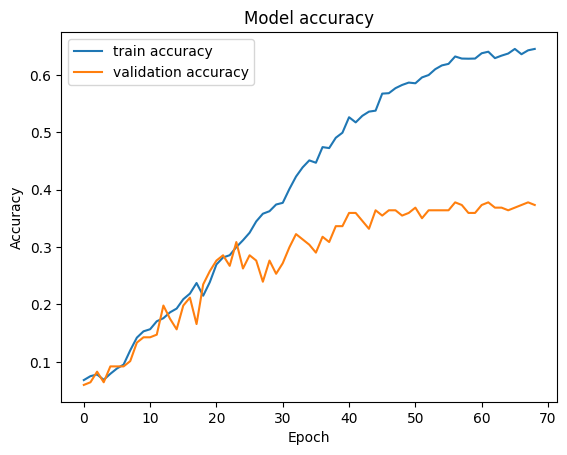

In [10]:
google_net_wrapper.plot_accuracy()

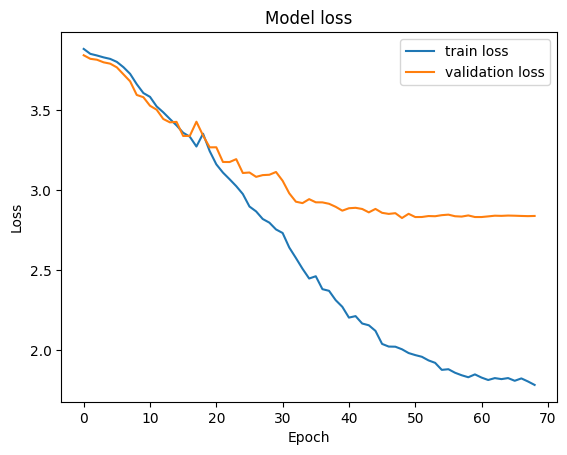

In [11]:
google_net_wrapper.plot_loss()

20/20 [==============================] - 0s 11ms/step


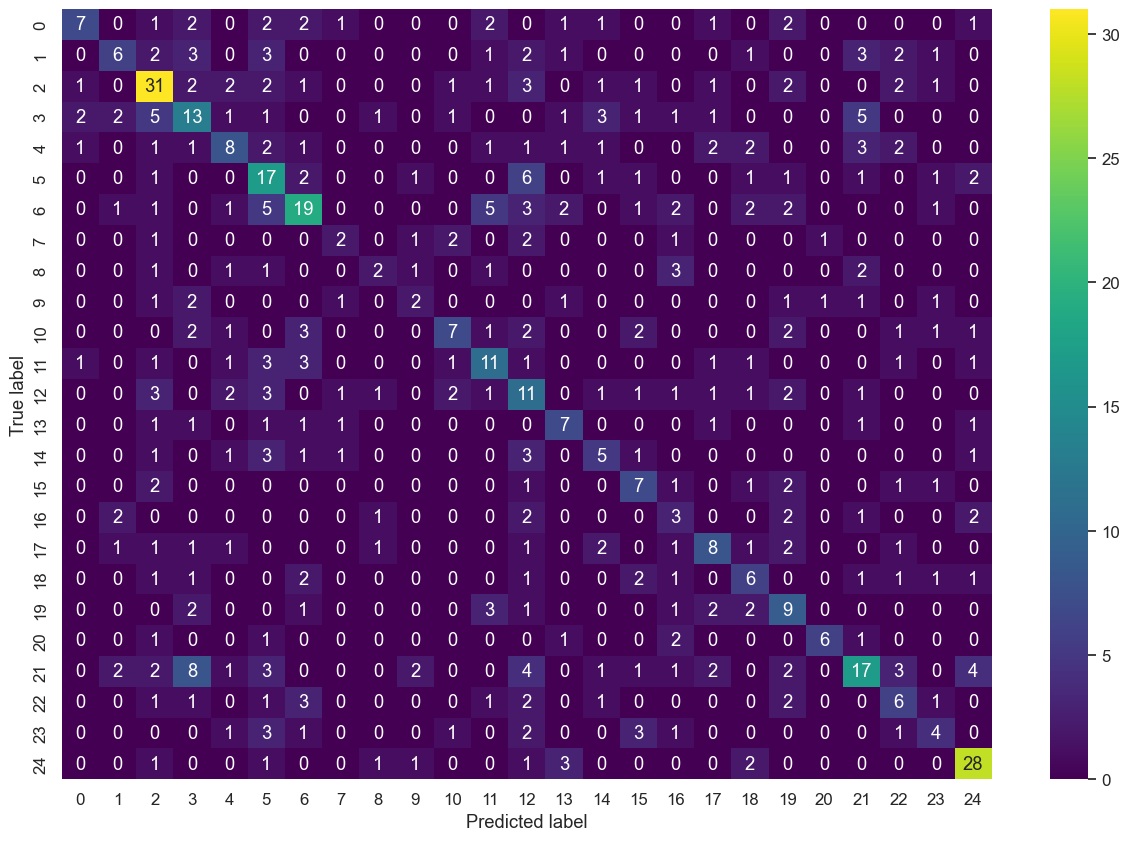

In [12]:
google_net_wrapper.display_confusion_matrix()